## 2D Case - Figures 12-13-15
Convergence to reference solution for training performed
using Adam and L-BFGS.

We investigate the effect of r-adaptivity and rh-adaptivity on the accuracy of displacement and von Mises stress.

In [1]:
#%% Libraries import
# import HiDeNN library
import sys  
# sys.path.append("../neurom/")
from neurom.HiDeNN_PDE import MeshNN, NeuROM, MeshNN_2D, MeshNN_1D
# Import pre-processing functions
import neurom.src.Pre_processing as pre
# Import torch librairies
import torch
import torch.nn as nn
# Import mechanical functions
from neurom.src.PDE_Library import Strain, Stress,VonMises_plain_strain
# Import Training funcitons
from neurom.src.Training import Training_2D_FEM
#Import post processing libraries
import neurom.Post.Plots as Pplot
import time
import os
import torch._dynamo as dynamo
mps_device = torch.device("mps")
from importlib import reload  # Python 3.4+
import tomllib
import numpy as numpy
import argparse



* Executing job in Configuration/config_2D.toml
* WARNING: could not load tikzplotlib


In [2]:
Default_config_file = 'Configurations/config_2D.toml'

with open(Default_config_file, mode="rb") as f:
    config = tomllib.load(f)

In [3]:
# Prerequisites
mesh_resolution = [44, 144, 484, 1804, 7088 ]

eval_coord_file = "GroundTruth/eval_coordinates.npy"
num_displ_file = "GroundTruth/num_displacement.npy"
num_VM_stress_file = "GroundTruth/num_VM_stress.npy"
eval_coord =  torch.tensor(numpy.load(eval_coord_file), dtype=torch.float64, requires_grad=True)
num_displ = torch.tensor(numpy.load(num_displ_file))
num_VM_stress = torch.tensor(numpy.load(num_VM_stress_file))

# Experiment
element_size = [2.0, 1.0, 0.5, 0.25, 0.125]
config["solver"]["FrozenMesh"] = True
optimizers = ["adam","lbfgs"]

error_u = numpy.zeros((len(element_size),len(optimizers)))
error_v = numpy.zeros((len(element_size),len(optimizers)))
error_stress = numpy.zeros((len(element_size),len(optimizers)))
error_stress_max = numpy.zeros((len(element_size),len(optimizers)))

for e in range(len(element_size)):
    config["interpolation"]["MaxElemSize2D"] = element_size[e]
    for op in range(len(optimizers)):
        config["training"]["optimizer"] = optimizers[op]

        if config["interpolation"]["dimension"] == 1:
            Mat = pre.Material(             flag_lame = True,                               # If True should input lmbda and mu instead of E and nu
                                            coef1     = config["material"]["E"],            # Young Modulus
                                            coef2     = config["geometry"]["A"]             # Section area of the 1D bar
                                )
        elif config["interpolation"]["dimension"] == 2:
            try:
                Mat = pre.Material(         flag_lame = False,                              # If True should input lmbda and mu instead of E and nu
                                            coef1     = config["material"]["E"],            # Young Modulus
                                            coef2     = config["material"]["nu"]            # Poisson's ratio
                                )
            except:
                Mat = pre.Material(         flag_lame = True,                               # If True should input lmbda and mu instead of E and nu
                                            coef1     = config["material"]["lmbda"],        # First Lame's coef
                                            coef2     = config["material"]["mu"]            # Second Lame's coef
                                )

        MaxElemSize = pre.ElementSize(
                                        dimension     = config["interpolation"]["dimension"],
                                        L             = config["geometry"]["L"],
                                        order         = config["interpolation"]["order"],
                                        np            = config["interpolation"]["np"],
                                        MaxElemSize2D = config["interpolation"]["MaxElemSize2D"]
                                    )
        Excluded = []
        Mesh_object = pre.Mesh( 
                                        config["geometry"]["Name"],                 # Create the mesh object
                                        MaxElemSize, 
                                        config["interpolation"]["order"], 
                                        config["interpolation"]["dimension"]
                                )

        Mesh_object.AddBorders(config["Borders"]["Borders"])
        Mesh_object.AddBCs(                                                         # Include Boundary physical domains infos (BCs+volume)
                                        config["geometry"]["Volume_element"],
                                        Excluded,
                                        config["DirichletDictionryList"]
                            )                   

        Mesh_object.MeshGeo()                                                       # Mesh the .geo file if .msh does not exist
        Mesh_object.ReadMesh()                                                      # Parse the .msh file
        Mesh_object.ExportMeshVtk()

        if int(Mesh_object.dim) != int(Mesh_object.dimension):
            raise ValueError("The dimension of the provided geometry does not match the job dimension")

        Model_FEM = MeshNN_2D(Mesh_object, n_components = 2)

        Model_FEM.Freeze_Mesh()
        Model_FEM.UnFreeze_FEM()

        if not config["solver"]["FrozenMesh"]:
            Model_FEM.UnFreeze_Mesh() 

        Model_FEM.RefinementParameters( MaxGeneration = config["training"]["h_adapt_MaxGeneration"], 
                                    Jacobian_threshold = config["training"]["h_adapt_J_thrshld"])

        Model_FEM.TrainingParameters(   loss_decrease_c = config["training"]["loss_decrease_c"], 
                                        Max_epochs = config["training"]["n_epochs"], 
                                        learning_rate = config["training"]["learning_rate"])
        Model_FEM = Training_2D_FEM(Model_FEM, config, Mat)
        
        # evaluation 
        Model_FEM.eval()

        elem_IDs = torch.tensor(Model_FEM.mesh.GetCellIds(eval_coord),dtype=torch.int)
        u = Model_FEM(eval_coord, elem_IDs)
        eps =  Strain(u,eval_coord)
        sigma =  torch.stack(Stress(eps[:,0], eps[:,1], eps[:,2], Mat.lmbda, Mat.mu),dim=1)
        sigma_VM = VonMises_plain_strain(sigma, Mat.lmbda, Mat.mu)

        error_u[e,op] = (torch.linalg.vector_norm(num_displ[:,0] - u[0,:])/torch.linalg.vector_norm(num_displ[:,0])).item()
        error_v[e,op] = (torch.linalg.vector_norm(num_displ[:,1] - u[1,:])/torch.linalg.vector_norm(num_displ[:,1])).item()
        error_stress[e,op] = (torch.linalg.vector_norm(num_VM_stress - sigma_VM)/torch.linalg.vector_norm(num_VM_stress)).item()
        error_stress_max[e,op] = (max(sigma_VM)/max(num_VM_stress)).item()



 
 
   _   _            ____   ___  __  __ 
  | \ | | ___ _   _|  _ \ / _ \|  \/  |
  |  \| |/ _ \ | | | |_) | | | | |\/| |
  | |\  |  __/ |_| |  _ <| |_| | |  | |
  |_| \_|\___|\__,_|_| \_\ ___/|_|  |_|

                  2024.09.18

************ MESH READING COMPLETE ************

 * Dimension of the problem: 2D
 * Elements type:            t3: 3-node triangle
 * Number of Dofs:           88

* Refinement level: 0

**************** START TRAINING ***************

epoch 2 loss = 6.4658e+00
epoch 50 loss = 5.3128e+00
epoch 100 loss = 4.3189e+00
epoch 150 loss = 3.5167e+00
epoch 200 loss = 2.8793e+00
epoch 250 loss = 2.3809e+00
epoch 300 loss = 1.9973e+00
epoch 350 loss = 1.7064e+00
epoch 400 loss = 1.4891e+00
epoch 450 loss = 1.3290e+00
epoch 500 loss = 1.2127e+00
epoch 550 loss = 1.1292e+00
epoch 600 loss = 1.0699e+00
epoch 650 loss = 1.0283e+00
epoch 700 loss = 9.9946e-01
epoch 750 loss = 9.7968e-01
epoch 800 loss = 9.6627e-01
epoch 850 loss = 9.5729e-01
epoch 900 loss = 9.5137e-01
e

In [4]:
print("Adam")
print("u = ", error_u[:,0])
print("v = ", error_v[:,0])
print("s = ", error_stress[:,0])
print("s max = ", error_stress_max[:,0])
print()
print("LBFGS")
print("u = ", error_u[:,1])
print("v = ", error_v[:,1])
print("s = ", error_stress[:,1])
print("s max = ", error_stress_max[:,1])

Adam
u =  [0.1878323  0.10327197 0.0385544  0.02584601 0.08669397]
v =  [0.02597361 0.01095467 0.0034613  0.00133766 0.00227587]
s =  [0.2297074  0.14719949 0.08269867 0.04360195 0.02777556]
s max =  [0.65601306 0.77541657 0.93797908 0.95440446 1.00013897]

LBFGS
u =  [0.18588991 0.10080447 0.03665099 0.00976878 0.00170569]
v =  [0.02586959 0.01065384 0.00328927 0.00084035 0.00015746]
s =  [0.22989806 0.14733525 0.08272104 0.04314683 0.02197674]
s max =  [0.65594826 0.77632042 0.93821257 0.95494388 0.99343906]


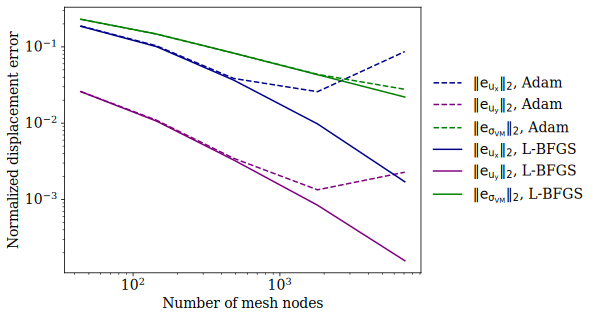

In [5]:
import matplotlib.pyplot as plt
import matplotlib
plt.rcParams['text.usetex'] = False

# Plot normalized displacement error

fig = matplotlib.pyplot.gcf()
ax = plt.gca()

plt.plot(mesh_resolution, error_u[:,0],'--', color = "darkblue", label = r'$\| e_{u_x}\|_2$'+ ", Adam")
plt.plot(mesh_resolution, error_v[:,0],'--', color = "purple", label = r'$\| e_{u_y}\|_2$'+ ", Adam")
plt.plot(mesh_resolution, error_stress[:,0],'--', color = "green", label = r'$\| e_{\sigma_{VM}}\|_2$'+ ", Adam")

plt.plot(mesh_resolution, error_u[:,1],'-', color = "darkblue", label = r'$\| e_{u_x}\|_2$'+ ", L-BFGS")
plt.plot(mesh_resolution, error_v[:,1],'-', color = "purple", label = r'$\| e_{u_y}\|_2$'+ ", L-BFGS")
plt.plot(mesh_resolution, error_stress[:,1],'-', color = "green", label = r'$\| e_{\sigma_{VM}}\|_2$'+ ", L-BFGS")


ax.set_xscale('log')
ax.set_yscale('log')

plt.xlabel("Number of mesh nodes")
plt.ylabel("Normalized displacement error")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),frameon=False )

plt.show()


In [6]:
# Prerequisites
mesh_resolution = [44, 144, 484, 1804, 7088 ]

# eval_coord_file = "../2D_example/eval_coordinates.npy"
# num_displ_file = "../2D_example/num_solution/num_displacement.npy"
# num_VM_stress_file = "../2D_example/num_solution/num_VM_stress.npy"
eval_coord_file = "GroundTruth/eval_coordinates.npy"
num_displ_file = "GroundTruth/num_displacement.npy"
num_VM_stress_file = "GroundTruth/num_VM_stress.npy"

eval_coord =  torch.tensor(numpy.load(eval_coord_file), dtype=torch.float64, requires_grad=True)
num_displ = torch.tensor(numpy.load(num_displ_file))
num_VM_stress = torch.tensor(numpy.load(num_VM_stress_file))

# Experiment
element_size = 2.0
config["solver"]["FrozenMesh"] = False
optimizers = ["adam","lbfgs"]
refinment = [1,2,3,4,5]

config["interpolation"]["MaxElemSize2D"] = element_size

r_adapt_error_u = numpy.zeros((len(refinment),len(optimizers)))
r_adapt_error_v = numpy.zeros((len(refinment),len(optimizers)))
r_adapt_error_stress = numpy.zeros((len(refinment),len(optimizers)))
r_adapt_error_stress_max = numpy.zeros((len(refinment),len(optimizers)))

for e in range(len(refinment)):
    config["training"]["multiscl_max_refinment"] = refinment[e]
    for op in range(len(optimizers)):
        config["training"]["optimizer"] = optimizers[op]

        Mat = pre.Material(             flag_lame = True,                          # If True should input lmbda and mu instead of E and nu
                                        coef1     = config["material"]["lmbda"],        # Young Modulus
                                        coef2     = config["material"]["mu"]        # Poisson's ratio
                            )

        MaxElemSize = pre.ElementSize(
                                        dimension     = config["interpolation"]["dimension"],
                                        L             = config["geometry"]["L"],
                                        order         = config["interpolation"]["order"],
                                        np            = config["interpolation"]["np"],
                                        MaxElemSize2D = config["interpolation"]["MaxElemSize2D"]
                                    )
        Excluded = []
        Mesh_object = pre.Mesh( 
                                        config["geometry"]["Name"],                 # Create the mesh object
                                        MaxElemSize, 
                                        config["interpolation"]["order"], 
                                        config["interpolation"]["dimension"]
                                )

        Mesh_object.AddBorders(config["Borders"]["Borders"])
        Mesh_object.AddBCs(                                                         # Include Boundary physical domains infos (BCs+volume)
                                        config["geometry"]["Volume_element"],
                                        Excluded,
                                        config["DirichletDictionryList"]
                            )                   

        Mesh_object.MeshGeo()                                                       # Mesh the .geo file if .msh does not exist
        Mesh_object.ReadMesh()                                                      # Parse the .msh file
        Mesh_object.ExportMeshVtk()

        if int(Mesh_object.dim) != int(Mesh_object.dimension):
            raise ValueError("The dimension of the provided geometry does not match the job dimension")

        Model_FEM = MeshNN_2D(Mesh_object, n_components = 2)

        Model_FEM.Freeze_Mesh()
        Model_FEM.UnFreeze_FEM()

        if not config["solver"]["FrozenMesh"]:
            Model_FEM.UnFreeze_Mesh() 

        Model_FEM.RefinementParameters( MaxGeneration = config["training"]["h_adapt_MaxGeneration"], 
                                    Jacobian_threshold = config["training"]["h_adapt_J_thrshld"])

        Model_FEM.TrainingParameters(   loss_decrease_c = config["training"]["loss_decrease_c"], 
                                        Max_epochs = config["training"]["n_epochs"], 
                                        learning_rate = config["training"]["learning_rate"])
        Model_FEM = Training_2D_FEM(Model_FEM, config, Mat)
        
        # evaluation 
        Model_FEM.eval()

        # Model_FEM.mesh.Nodes = [[i+1,Model_FEM.coordinates[i][0][0].item(),Model_FEM.coordinates[i][0][1].item(),0] for i in range(len(Model_FEM.coordinates))]
        coordinates_all = torch.ones_like(Model_FEM.coordinates_all)
        coordinates_all[Model_FEM.coord_free] = Model_FEM.coordinates['free']
        coordinates_all[~Model_FEM.coord_free] = Model_FEM.coordinates['imposed']
        Nodes = torch.hstack([torch.linspace(1,coordinates_all.shape[0],coordinates_all.shape[0], dtype = coordinates_all.dtype, device = coordinates_all.device)[:,None],
                                coordinates_all])
        Nodes = torch.hstack([Nodes,torch.zeros(Nodes.shape[0],1, dtype = Nodes.dtype, device = Nodes.device)])
        Model_FEM.mesh.Nodes = Nodes.detach().cpu().numpy()
        Model_FEM.mesh.Connectivity = Model_FEM.connectivity
        Model_FEM.mesh.ExportMeshVtk(flag_update = True)

        elem_IDs = torch.tensor(Model_FEM.mesh.GetCellIds(eval_coord),dtype=torch.int)
        u = Model_FEM(eval_coord, elem_IDs)
        eps =  Strain(u,eval_coord)
        sigma =  torch.stack(Stress(eps[:,0], eps[:,1], eps[:,2], Mat.lmbda, Mat.mu),dim=1)
        sigma_VM = VonMises_plain_strain(sigma, Mat.lmbda, Mat.mu)

        r_adapt_error_u[e,op] = (torch.linalg.vector_norm(num_displ[:,0] - u[0,:])/torch.linalg.vector_norm(num_displ[:,0])).item()
        r_adapt_error_v[e,op] = (torch.linalg.vector_norm(num_displ[:,1] - u[1,:])/torch.linalg.vector_norm(num_displ[:,1])).item()
        r_adapt_error_stress[e,op] = (torch.linalg.vector_norm(num_VM_stress - sigma_VM)/torch.linalg.vector_norm(num_VM_stress)).item()
        r_adapt_error_stress_max[e,op] = (max(sigma_VM)/max(num_VM_stress)).item()



 
 
   _   _            ____   ___  __  __ 
  | \ | | ___ _   _|  _ \ / _ \|  \/  |
  |  \| |/ _ \ | | | |_) | | | | |\/| |
  | |\  |  __/ |_| |  _ <| |_| | |  | |
  |_| \_|\___|\__,_|_| \_\ ___/|_|  |_|

                  2024.09.18

************ MESH READING COMPLETE ************

 * Dimension of the problem: 2D
 * Elements type:            t3: 3-node triangle
 * Number of Dofs:           88

* Refinement level: 0

**************** START TRAINING ***************

epoch 2 loss = 6.4619e+00
epoch 50 loss = 5.1704e+00
epoch 100 loss = 4.1221e+00
epoch 150 loss = 3.3192e+00
epoch 200 loss = 2.7077e+00
epoch 250 loss = 2.2451e+00
epoch 300 loss = 1.8976e+00
epoch 350 loss = 1.6385e+00
epoch 400 loss = 1.4464e+00
epoch 450 loss = 1.3049e+00
epoch 500 loss = 1.2011e+00
epoch 550 loss = 1.1253e+00
epoch 600 loss = 1.0702e+00
epoch 650 loss = 1.0304e+00
epoch 700 loss = 1.0018e+00
epoch 750 loss = 9.814e-01
epoch 800 loss = 9.6694e-01
epoch 850 loss = 9.5677e-01
epoch 900 loss = 9.4965e-01
ep

In [7]:
print("Adam")
print("u = ", r_adapt_error_u[:,0])
print("v = ", r_adapt_error_v[:,0])
print("s = ", r_adapt_error_stress[:,0])
print("s max = ", r_adapt_error_stress_max[:,0])
print()
print("LBFGS")
print("u = ", r_adapt_error_u[:,1])
print("v = ", r_adapt_error_v[:,1])
print("s = ", r_adapt_error_stress[:,1])
print("s max = ", r_adapt_error_stress_max[:,1])

Adam
u =  [0.19452372 0.07560274 0.02455851 0.00979111 0.00865349]
v =  [0.02543295 0.00813394 0.00240461 0.00074863 0.0004539 ]
s =  [0.21910054 0.11351486 0.06748505 0.03945204 0.02177264]
s max =  [0.68692235 0.87717278 1.01535961 0.99544879 1.01598016]

LBFGS
u =  [0.1964758  0.07483696 0.02378997 0.00619278 0.00083231]
v =  [0.02515145 0.00827428 0.00241591 0.00058403 0.00012013]
s =  [0.2195726  0.11374515 0.06448546 0.03514965 0.01992995]
s max =  [0.68675181 0.87801194 0.95702206 0.99308209 0.9965984 ]


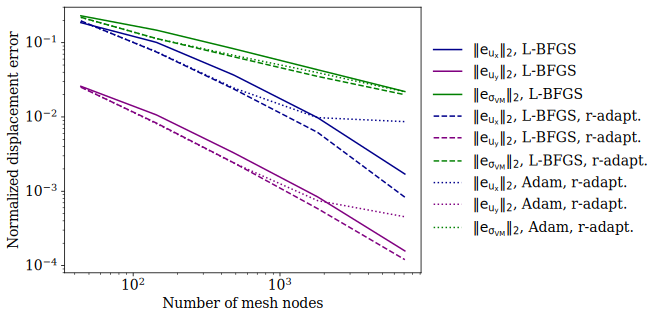

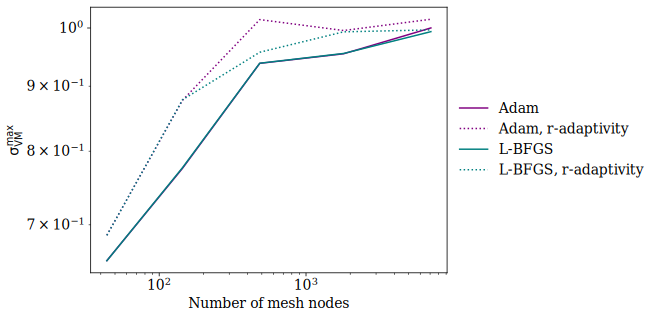

In [8]:
# Plot normalized displacement error

fig = matplotlib.pyplot.gcf()
ax = plt.gca()

plt.plot(mesh_resolution, error_u[:,1],'-', color = "darkblue", label = r'$\| e_{u_x}\|_2$'+ ", L-BFGS")
plt.plot(mesh_resolution, error_v[:,1],'-', color = "purple", label = r'$\| e_{u_y}\|_2$'+ ", L-BFGS")
plt.plot(mesh_resolution, error_stress[:,1],'-', color = "green", label = r'$\| e_{\sigma_{VM}}\|_2$'+ ", L-BFGS")

plt.plot(mesh_resolution, r_adapt_error_u[:,1],'--', color = "darkblue", label = r'$\| e_{u_x}\|_2$'+ ", L-BFGS, r-adapt.")
plt.plot(mesh_resolution, r_adapt_error_v[:,1],'--', color = "purple", label = r'$\| e_{u_y}\|_2$'+ ", L-BFGS, r-adapt.")
plt.plot(mesh_resolution, r_adapt_error_stress[:,1],'--', color = "green", label = r'$\| e_{\sigma_{VM}}\|_2$'+ ", L-BFGS, r-adapt.")

plt.plot(mesh_resolution, r_adapt_error_u[:,0],':', color = "darkblue", label = r'$\| e_{u_x}\|_2$'+ ", Adam, r-adapt.")
plt.plot(mesh_resolution, r_adapt_error_v[:,0],':', color = "purple", label = r'$\| e_{u_y}\|_2$'+ ", Adam, r-adapt.")
plt.plot(mesh_resolution, r_adapt_error_stress[:,0],':', color = "green", label = r'$\| e_{\sigma_{VM}}\|_2$'+ ", Adam, r-adapt.")

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim([0.00008, 0.3])

plt.xlabel("Number of mesh nodes")
plt.ylabel("Normalized displacement error")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),frameon=False )

plt.show()

# Plot maximal stress

fig = matplotlib.pyplot.gcf()
ax = plt.gca()

plt.plot(mesh_resolution, error_stress_max[:,0],'-', color = "purple", label = "Adam")
plt.plot(mesh_resolution, r_adapt_error_stress_max[:,0],':', color = "purple", label = "Adam, r-adaptivity")
plt.plot(mesh_resolution, error_stress_max[:,1],'-', color = "teal", label = "L-BFGS")
plt.plot(mesh_resolution, r_adapt_error_stress_max[:,1],':', color = "teal", label =  "L-BFGS, r-adaptivity")

ax.set_xscale('log')
ax.set_yscale('log')

plt.xlabel("Number of mesh nodes")
plt.ylabel(r'$\sigma^{max}_{VM}$')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),frameon=False )

plt.show()


In [9]:

# Prerequisites
mesh_resolution = [44, 144, 484, 1804, 7088 ]

# eval_coord_file = "../2D_example/eval_coordinates.npy"
# num_displ_file = "../2D_example/num_solution/num_displacement.npy"
# num_VM_stress_file = "../2D_example/num_solution/num_VM_stress.npy"

eval_coord_file = "GroundTruth/eval_coordinates.npy"
num_displ_file = "GroundTruth/num_displacement.npy"
num_VM_stress_file = "GroundTruth/num_VM_stress.npy"

eval_coord =  torch.tensor(numpy.load(eval_coord_file), dtype=torch.float64, requires_grad=True)
num_displ = torch.tensor(numpy.load(num_displ_file))
num_VM_stress = torch.tensor(numpy.load(num_VM_stress_file))

# Experiment
element_size = 2.0
config["solver"]["FrozenMesh"] = False
optimizer = "lbfgs"
refinment = [1,2,3,4,5]

config["interpolation"]["MaxElemSize2D"] = element_size
config["training"]["optimizer"] = optimizer
config["training"]["h_adapt_MaxGeneration"] = 2

rh_adapt_error_u = numpy.zeros((len(refinment)))
rh_adapt_error_v = numpy.zeros((len(refinment)))
rh_adapt_error_stress = numpy.zeros((len(refinment)))
rh_adapt_error_stress_max = numpy.zeros((len(refinment)))

for e in range(len(refinment)):
    config["training"]["multiscl_max_refinment"] = refinment[e]

    Mat = pre.Material(             flag_lame = True,                          # If True should input lmbda and mu instead of E and nu
                                    coef1     = config["material"]["lmbda"],        # Young Modulus
                                    coef2     = config["material"]["mu"]        # Poisson's ratio
                        )

    MaxElemSize = pre.ElementSize(
                                    dimension     = config["interpolation"]["dimension"],
                                    L             = config["geometry"]["L"],
                                    order         = config["interpolation"]["order"],
                                    np            = config["interpolation"]["np"],
                                    MaxElemSize2D = config["interpolation"]["MaxElemSize2D"]
                                )
    Excluded = []
    Mesh_object = pre.Mesh( 
                                    config["geometry"]["Name"],                 # Create the mesh object
                                    MaxElemSize, 
                                    config["interpolation"]["order"], 
                                    config["interpolation"]["dimension"]
                            )

    Mesh_object.AddBorders(config["Borders"]["Borders"])
    Mesh_object.AddBCs(                                                         # Include Boundary physical domains infos (BCs+volume)
                                    config["geometry"]["Volume_element"],
                                    Excluded,
                                    config["DirichletDictionryList"]
                        )                   

    Mesh_object.MeshGeo()                                                       # Mesh the .geo file if .msh does not exist
    Mesh_object.ReadMesh()                                                      # Parse the .msh file
    Mesh_object.ExportMeshVtk()

    if int(Mesh_object.dim) != int(Mesh_object.dimension):
        raise ValueError("The dimension of the provided geometry does not match the job dimension")

    Model_FEM = MeshNN_2D(Mesh_object, n_components = 2)

    Model_FEM.Freeze_Mesh()
    Model_FEM.UnFreeze_FEM()

    if not config["solver"]["FrozenMesh"]:
        Model_FEM.UnFreeze_Mesh() 

    Model_FEM.RefinementParameters( MaxGeneration = config["training"]["h_adapt_MaxGeneration"], 
                                Jacobian_threshold = config["training"]["h_adapt_J_thrshld"])

    Model_FEM.TrainingParameters(   loss_decrease_c = config["training"]["loss_decrease_c"], 
                                    Max_epochs = config["training"]["n_epochs"], 
                                    learning_rate = config["training"]["learning_rate"])
    Model_FEM = Training_2D_FEM(Model_FEM, config, Mat)
    
    # evaluation 
    Model_FEM.eval()

    # Model_FEM.mesh.Nodes = [[i+1,Model_FEM.coordinates[i][0][0].item(),Model_FEM.coordinates[i][0][1].item(),0] for i in range(len(Model_FEM.coordinates))]
    coordinates_all = torch.ones_like(Model_FEM.coordinates_all)
    coordinates_all[Model_FEM.coord_free] = Model_FEM.coordinates['free']
    coordinates_all[~Model_FEM.coord_free] = Model_FEM.coordinates['imposed']
    Nodes = torch.hstack([torch.linspace(1,coordinates_all.shape[0],coordinates_all.shape[0], dtype = coordinates_all.dtype, device = coordinates_all.device)[:,None],
                            coordinates_all])
    Nodes = torch.hstack([Nodes,torch.zeros(Nodes.shape[0],1, dtype = Nodes.dtype, device = Nodes.device)])
    Model_FEM.mesh.Nodes = Nodes.detach().cpu().numpy()
    Model_FEM.mesh.Connectivity = Model_FEM.connectivity
    Model_FEM.mesh.ExportMeshVtk(flag_update = True)

    elem_IDs = torch.tensor(Model_FEM.mesh.GetCellIds(eval_coord),dtype=torch.int)
    u = Model_FEM(eval_coord, elem_IDs)
    eps =  Strain(u,eval_coord)
    sigma =  torch.stack(Stress(eps[:,0], eps[:,1], eps[:,2], Mat.lmbda, Mat.mu),dim=1)
    sigma_VM = VonMises_plain_strain(sigma, Mat.lmbda, Mat.mu)

    rh_adapt_error_u[e] = (torch.linalg.vector_norm(num_displ[:,0] - u[0,:])/torch.linalg.vector_norm(num_displ[:,0])).item()
    rh_adapt_error_v[e] = (torch.linalg.vector_norm(num_displ[:,1] - u[1,:])/torch.linalg.vector_norm(num_displ[:,1])).item()
    rh_adapt_error_stress[e] = (torch.linalg.vector_norm(num_VM_stress - sigma_VM)/torch.linalg.vector_norm(num_VM_stress)).item()
    rh_adapt_error_stress_max[e] = (max(sigma_VM)/max(num_VM_stress)).item()



 
 
   _   _            ____   ___  __  __ 
  | \ | | ___ _   _|  _ \ / _ \|  \/  |
  |  \| |/ _ \ | | | |_) | | | | |\/| |
  | |\  |  __/ |_| |  _ <| |_| | |  | |
  |_| \_|\___|\__,_|_| \_\ ___/|_|  |_|

                  2024.09.18

************ MESH READING COMPLETE ************

 * Dimension of the problem: 2D
 * Elements type:            t3: 3-node triangle
 * Number of Dofs:           88

* Refinement level: 0

**************** START TRAINING ***************

epoch 2 loss = 9.4093e-01
epoch 3 loss = 9.3267e-01
epoch 4 loss = 9.3022e-01
epoch 5 loss = 9.3013e-01
epoch 6 loss = 9.2284e-01
epoch 7 loss = 9.2015e-01
epoch 8 loss = 9.1919e-01
epoch 9 loss = 9.1822e-01
epoch 10 loss = 9.1781e-01
epoch 11 loss = 9.1773e-01
epoch 12 loss = 9.1767e-01
epoch 13 loss = 9.1766e-01
epoch 14 loss = 9.1766e-01
epoch 15 loss = 9.1766e-01
epoch 16 loss = 9.1766e-01
epoch 17 loss = 9.1766e-01
epoch 18 loss = 9.1766e-01
*************** END FIRST PHASE ***************

* Training time: 0.66469407081

In [10]:
print("LBFGS")
print("u = ", rh_adapt_error_u[:])
print("v = ", rh_adapt_error_v[:])
print("s = ", rh_adapt_error_stress[:])
print("s max = ", rh_adapt_error_stress_max[:])


LBFGS
u =  [0.1613041  0.05543183 0.02019657 0.00428556 0.0009745 ]
v =  [0.02091463 0.00601936 0.0020075  0.00044092 0.00012973]
s =  [0.20231483 0.09395327 0.06183964 0.03117634 0.02013201]
s max =  [0.85569806 0.97563867 1.00978807 1.00608271 0.98011422]


(5,)


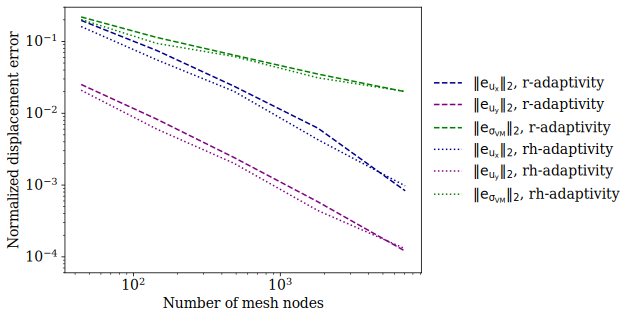

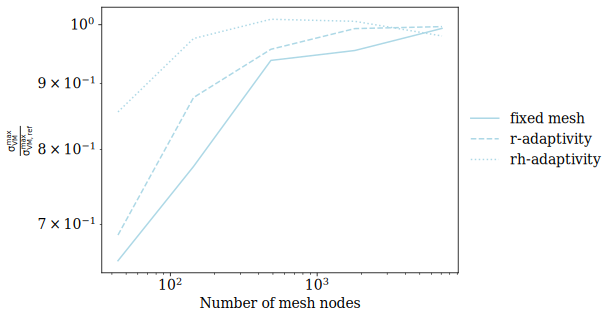

In [11]:
# Plot normalized displacement error

fig = matplotlib.pyplot.gcf()
ax = plt.gca()

print(rh_adapt_error_u.shape)

plt.plot(mesh_resolution, r_adapt_error_u[:,1],'--', color = "darkblue", label = r'$\| e_{u_x}\|_2$'+ ", r-adaptivity")
plt.plot(mesh_resolution, r_adapt_error_v[:,1],'--', color = "purple", label = r'$\| e_{u_y}\|_2$'+ ", r-adaptivity")
plt.plot(mesh_resolution, r_adapt_error_stress[:,1],'--', color = "green", label = r'$\| e_{\sigma_{VM}}\|_2$'+ ", r-adaptivity")

plt.plot(mesh_resolution, rh_adapt_error_u,':', color = "darkblue", label = r'$\| e_{u_x}\|_2$'+ ", rh-adaptivity")
plt.plot(mesh_resolution, rh_adapt_error_v,':', color = "purple", label = r'$\| e_{u_y}\|_2$'+ ", rh-adaptivity")
plt.plot(mesh_resolution, rh_adapt_error_stress,':', color = "green", label = r'$\| e_{\sigma_{VM}}\|_2$'+ ", rh-adaptivity")


ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim([0.00006, 0.3])

plt.xlabel("Number of mesh nodes")
plt.ylabel("Normalized displacement error")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),frameon=False )

plt.show()

# Plot maximal stress

fig = matplotlib.pyplot.gcf()
ax = plt.gca()

plt.plot(mesh_resolution, error_stress_max[:,1],'-', color = "lightblue", label = "fixed mesh")
plt.plot(mesh_resolution, r_adapt_error_stress_max[:,1],'--', color = "lightblue", label =  "r-adaptivity")
plt.plot(mesh_resolution, rh_adapt_error_stress_max,':', color = "lightblue", label =  "rh-adaptivity")

ax.set_xscale('log')
ax.set_yscale('log')

plt.xlabel("Number of mesh nodes")
# plt.ylabel(r'$\sigma^{max}_{VM}$')
plt.ylabel(r'$\frac{\sigma_{VM}^{max}}{\sigma_{VM, ref}^{max}}$')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),frameon=False )

plt.show()
